In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import *
import random
import numpy as np
import pickle

import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv

from model import Encoder,WeightSumDecoder
from data import get_feature,standardize_matrix,get_zt
from utils import mins_cross_entropy,shuffle_rows,visualize_weighted_graph

In [2]:
s = 2050
torch.manual_seed(s)
np.random.seed(s)
random.seed(s)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## load dataset

In [3]:
with open('./data/train_adjs.pkl','rb') as f:
    train_adjs=pickle.load(f)
with open('./data/valid_adjs.pkl','rb') as f:
    valid_adjs=pickle.load(f)
with open('./data/test_adjs.pkl','rb') as f:
    test_adjs=pickle.load(f)
    
with open('./data/train_feas.pkl','rb') as f:
    train_feas=pickle.load(f)
with open('./data/valid_feas.pkl','rb') as f:
    valid_feas=pickle.load(f)
with open('./data/test_feas.pkl','rb') as f:
    test_feas=pickle.load(f)
    
with open('./data/train_names.pkl','rb') as f:
    train_names=pickle.load(f)
with open('./data/valid_names.pkl','rb') as f:
    valid_names=pickle.load(f)
with open('./data/test_names.pkl','rb') as f:
    test_names=pickle.load(f)
    
with open('./data/train_zts.pkl','rb') as f:
    train_zts=pickle.load(f)
with open('./data/valid_zts.pkl','rb') as f:
    valid_zts=pickle.load(f)
with open('./data/test_zts.pkl','rb') as f:
    test_zts=pickle.load(f)

### dataset property

In [4]:
len(train_feas),len(test_feas),len(valid_feas),len(train_feas)+len(test_feas)+len(valid_feas)

(1406, 412, 375, 2193)

In [5]:
node_nums_train = [train_feas[i].shape[0] for i in range(len(train_adjs))]
node_nums_valid = [valid_feas[i].shape[0] for i in range(len(valid_adjs))]
node_nums_test = [test_feas[i].shape[0] for i in range(len(test_adjs))]

In [6]:
max(node_nums_train),min(node_nums_train)

(1000, 100)

In [7]:
max(node_nums_valid),min(node_nums_valid)

(1000, 100)

In [8]:
max(node_nums_test),min(node_nums_test)

(2495, 1002)

## Define the model and optimizer

In [9]:
# Definition of Encoder
class Encoder(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim, n_layers):
        super(Encoder,self).__init__()
        self.convs = torch.nn.ModuleList()
        self.in_proj = torch.nn.Linear(input_dim, hidden_dim)
        nn_seq = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        for _ in range(n_layers):
            self.convs.append(GINConv(nn_seq))
        self.out_proj = torch.nn.Linear((n_layers+1)*hidden_dim+input_dim, output_dim)
    def forward(self,x0,edge_index):
        x = self.in_proj(x0)
        hidden_states = [x0,x]
        for layer in self.convs:
            x = layer(x,edge_index)
            hidden_states.append(x)
        x = torch.cat(hidden_states, dim=1)
        x = self.out_proj(x)
        x = F.softmax(x,dim=-1)
        return x

In [10]:
# every time we valid(or test), we select 30 samples(too much will be to long, and to few will be inaccurate) randomly from
# valid set and test set, renormalize them with trained model
# and compare the loss
def valid_model():
    l0s = []
    for b in range(30):
        ran = np.random.randint(len(valid_adjs))

        X = valid_feas[ran].float().to(device)
        f_mean = torch.mean(X,dim=0)
        eps=1e-7
        f_std = torch.std(X,dim=0)+eps
        X = (X-f_mean) / f_std
        edge_index = valid_adjs[ran]
        adj = torch_geometric.utils.to_dense_adj(edge_index)[0]
        y = valid_zts[ran]

        group = encoder(X,edge_index)
        new_p = decoder(group,adj.float())
        yhat = get_zt(new_p,ts).real
        l0 = torch.mean(torch.abs(y-yhat))
        l0s.append(l0.item())
    return np.mean(l0s)

def test_model():
    l0s = []
    for b in range(30):
        ran = np.random.randint(len(test_adjs))

        X = test_feas[ran].float().to(device)
        f_mean = torch.mean(X,dim=0)
        eps=1e-7
        f_std = torch.std(X,dim=0)+eps
        
        X = (X-f_mean) / f_std
        
        edge_index = test_adjs[ran]
        adj = torch_geometric.utils.to_dense_adj(edge_index)[0]
        y = test_zts[ran]

        group = encoder(X,edge_index)
        new_p = decoder(group,adj.float())
        yhat = get_zt(new_p,ts)
        l0 = torch.mean(torch.abs(y-yhat))
        l0s.append(l0.item())
    return np.mean(l0s)

## Start Training!

In [11]:
macro_node = 50
ts = np.logspace(-2,1.5,15,base=10).tolist()

In [12]:
encoder = Encoder(input_dim =5, hidden_dim = 64, output_dim = macro_node, n_layers = 1).to(device)
decoder = WeightSumDecoder(macro_node)
op = torch.optim.Adam(encoder.parameters(),lr=1e-4)
# record the loss
lss_train_0 = []
lss_train_1 = []
lss_ce = []

In [13]:
val_lss = []
test_lss = []

In [14]:
eps=1e-7
for e in tqdm(range(1500)):
    loss = 0
    l0s = 0
    l1s = 0
    l2s = 0
    for b in range(10):
        ran = np.random.randint(len(train_adjs))
        X = train_feas[ran].float().to(device)

        # -mean/std
        f_mean = torch.mean(X,dim=0)
        f_std = torch.std(X,dim=0)+eps
        X = (X-f_mean) / f_std

        
        edge_index = train_adjs[ran]
        adj = torch_geometric.utils.to_dense_adj(edge_index)[0]
        y = train_zts[ran].real
        # Partition function evaluation
        group = encoder(X,edge_index)
        new_p = decoder(group,adj.float())
        yhat = get_zt(new_p,ts).real
        y_tr = -torch.log(y)
        l0 = torch.mean(torch.abs(y-yhat))

        yhat_tr = -torch.log(yhat)
        # this l1 definition is useful for comparision for partitions when \tau is large, because when \tau is large, both y and
        # yhat will be very close to 0
        l1 = torch.mean(torch.abs(yhat_tr[:]-y_tr[:]))

        # Cross Entropy Loss exists to make nodes as seperate as possible, it will be helpful for training in most cases
        sgroup = shuffle_rows(group)
        l2 = mins_cross_entropy(sgroup,group)

        loss += l0*1+l1*0.001+l2*0.001# this weight should not be too large
        l1s += l1
        l0s += l0
        l2s += l2
    
    # backpropagation and gradient decent
    op.zero_grad()
    loss = loss/10
    loss.backward()
    
    op.step()
    
    # recording
    lss_train_0.append(l0s.item()/10)
    lss_train_1.append(l1s.item()/10)
    lss_ce.append(l2s.item()/10)
    
    if e%20 == 0:
        val_lss.append(valid_model())
        test_lss.append(test_model())

100%|██████████| 1500/1500 [01:32<00:00, 16.15it/s]


## Visualize loss curves

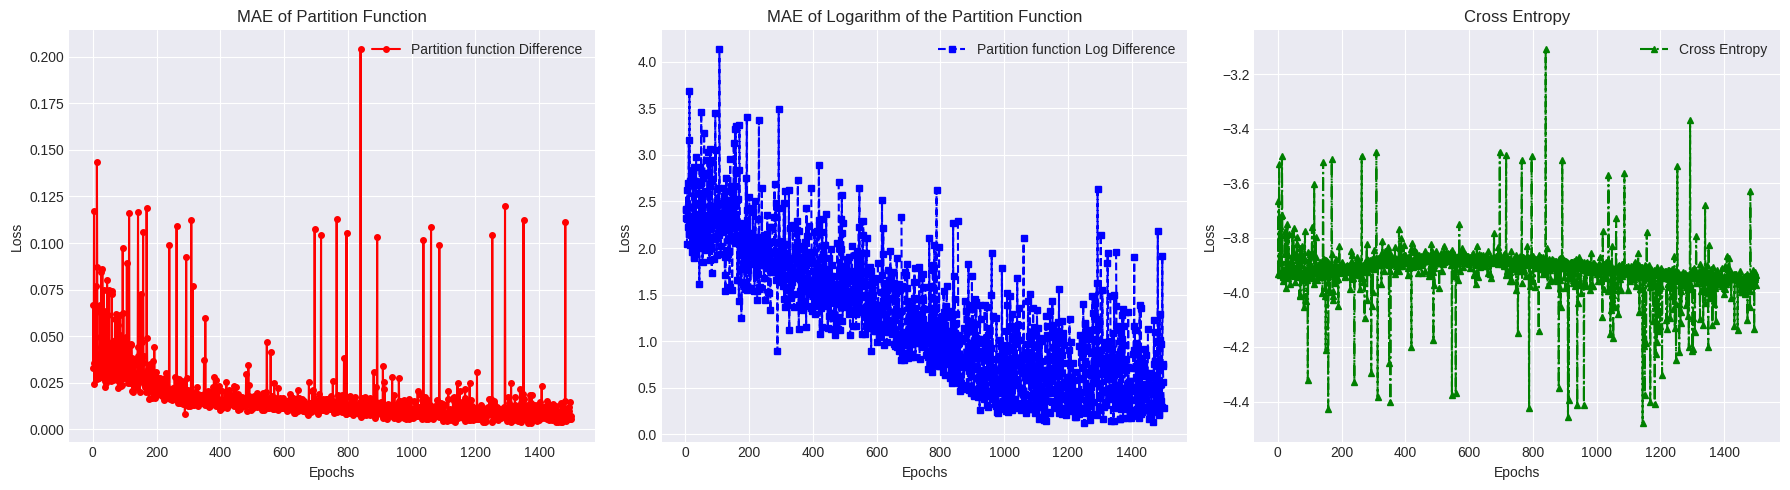

In [15]:

plt.style.use('seaborn-darkgrid')
epochs = range(1,len(lss_train_0)+1)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(epochs, lss_train_0, color='red', marker='o', linestyle='-', markersize=4, label='Partition function Difference')
axs[1].plot(epochs, lss_train_1, color='blue', marker='s', linestyle='--', markersize=4, label='Partition function Log Difference')
axs[2].plot(epochs, lss_ce, color='green', marker='^', linestyle='-.', markersize=4, label='Cross Entropy')

axs[0].set_title('MAE of Partition Function')
axs[1].set_title('MAE of Logarithm of the Partition Function')
axs[2].set_title('Cross Entropy')

for ax in axs:
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()

plt.show()

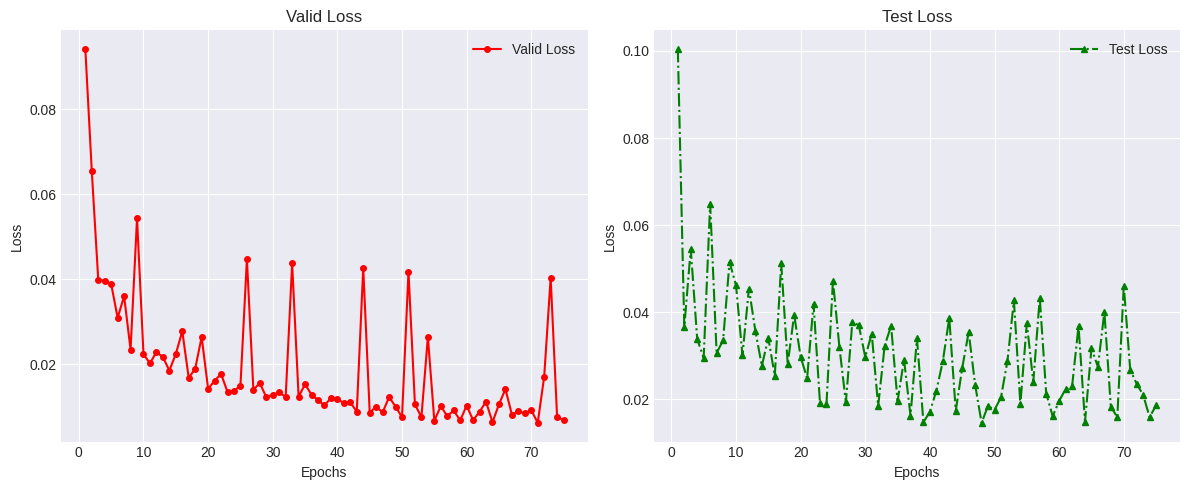

In [16]:

plt.style.use('seaborn-darkgrid')
epochs = range(1,len(val_lss)+1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(epochs, val_lss, color='red', marker='o', linestyle='-', markersize=4, label='Valid Loss')
axs[1].plot(epochs, test_lss, color='green', marker='^', linestyle='-.', markersize=4, label='Test Loss')
axs[0].set_title('Valid Loss')
axs[1].set_title('Test Loss')

for ax in axs:
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
plt.tight_layout()

plt.show()